In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [23]:
from read_and_clean import read_and_clean

In [24]:
orders_df = read_and_clean()

In [18]:
orders_df

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,City,Postal Code,Order Date,Ship Date,Profit,Quantity ordered new,Sales,Order ID,Year,Month
0,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,Anacortes,98221,2015-01-07,2015-01-08,4.5600,4,13.01,88522,2015,1
1,20228,Not Specified,0.02,500.98,26.00,5,Ronnie Proctor,Delivery Truck,Home Office,Furniture,...,San Gabriel,91776,2015-06-13,2015-06-15,4390.3665,12,6362.85,90193,2015,6
2,21776,Critical,0.06,9.48,7.29,11,Marcus Dunlap,Regular Air,Home Office,Furniture,...,Roselle,7203,2015-02-15,2015-02-17,-53.8096,22,211.15,90192,2015,2
3,24844,Medium,0.09,78.69,19.99,14,Gwendolyn F Tyson,Regular Air,Small Business,Furniture,...,Prior Lake,55372,2015-05-12,2015-05-14,803.4705,16,1164.45,86838,2015,5
4,24846,Medium,0.08,3.28,2.31,14,Gwendolyn F Tyson,Regular Air,Small Business,Office Supplies,...,Prior Lake,55372,2015-05-12,2015-05-13,-24.0300,7,22.23,86838,2015,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,19842,High,0.01,10.90,7.46,3397,Andrea Shaw,Regular Air,Small Business,Office Supplies,...,Danville,61832,2015-03-11,2015-03-12,-116.7600,18,207.31,87536,2015,3
1948,19843,High,0.10,7.99,5.03,3397,Andrea Shaw,Regular Air,Small Business,Technology,...,Danville,61832,2015-03-11,2015-03-12,-160.9520,22,143.12,87536,2015,3
1949,26208,Not Specified,0.08,11.97,5.81,3399,Marvin Reid,Regular Air,Small Business,Office Supplies,...,Des Plaines,60016,2015-03-29,2015-03-31,-41.8700,5,59.98,87534,2015,3
1950,24911,Medium,0.10,9.38,4.93,3400,Florence Gold,Express Air,Small Business,Furniture,...,Fairmont,26554,2015-04-04,2015-04-04,-24.7104,15,135.78,87537,2015,4


In [30]:
orders_df.columns

Index(['Row ID', 'Order Priority', 'Discount', 'Unit Price', 'Shipping Cost',
       'Customer ID', 'Customer Name', 'Ship Mode', 'Customer Segment',
       'Product Category', 'Product Sub-Category', 'Product Container',
       'Product Name', 'Product Base Margin', 'Country', 'Region',
       'State or Province', 'City', 'Postal Code', 'Order Date', 'Ship Date',
       'Profit', 'Quantity ordered new', 'Sales', 'Order ID', 'Year', 'Month'],
      dtype='object')

In [ ]:
# ----------- Step 1: Aggregate by Customer ----------- #
customer_df = orders_df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity ordered new': 'sum',
    'Shipping Cost': 'sum',
    'Unit Price': 'mean',
    'Product Base Margin': 'mean',
}).reset_index()
# Add segment back as categorical (most frequent per customer)
# If a customer appears with multiple segments, we choose the most frequent one
segment_info = orders_df.groupby('Customer ID')['Customer Segment'] \
                        .agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]) \
                        .reset_index()

# Merge back
customer_df = pd.merge(customer_df, segment_info, on='Customer ID', how='left')

# Optional: Add encoded segment info
segment_dummies = pd.get_dummies(orders_df[['Customer ID', 'Customer Segment']], drop_first=True)
segment_dummies = segment_dummies.groupby('Customer ID').max().reset_index()
customer_df = pd.merge(customer_df, segment_dummies, on='Customer ID', how='left')

# ----------- Step 2: Scale & Cluster ----------- #
# Save segment column for later
segment_col = customer_df['Customer Segment']

# Prepare features (excluding Customer ID and segment)
X = customer_df.drop(['Customer ID', 'Customer Segment'], axis=1)
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Add back segment for visualization
customer_df['Customer Segment'] = segment_col

# ----------- Step 3: Visualize ----------- #
# sns.pairplot(customer_df, hue='Cluster', diag_kind='kde')
# plt.suptitle('Customer Clustering', y=1.02)
# plt.show()

C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

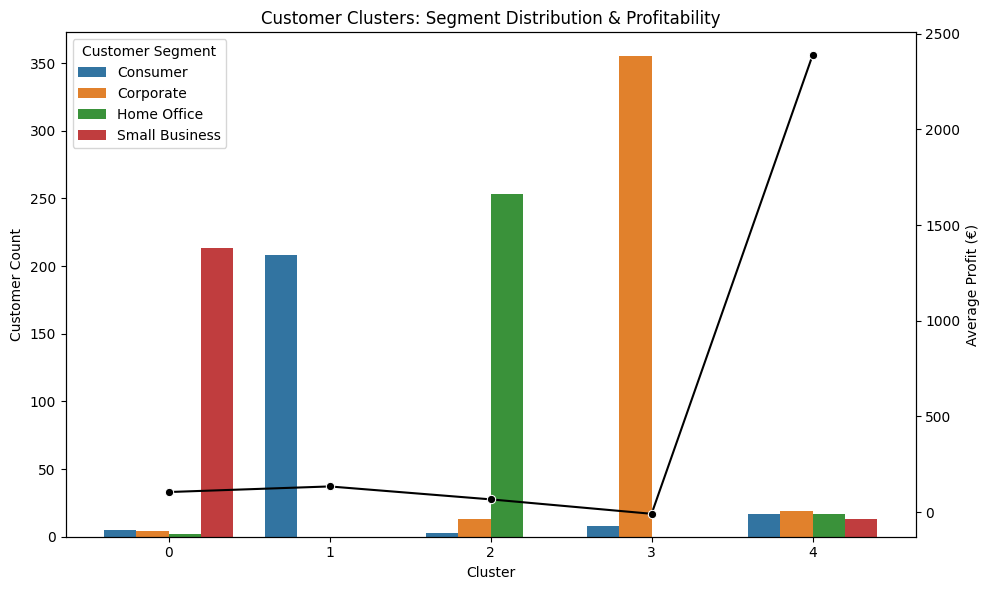

In [89]:
# ----------- Step 1: Customer counts per cluster & segment ----------- #
segment_counts = customer_df.groupby(['Cluster', 'Customer Segment']) \
                            .size().reset_index(name='Customer Count')

# ----------- Step 2: Average profit per cluster ----------- #
cluster_profit = customer_df.groupby('Cluster')['Profit'].mean().reset_index()

# ----------- Step 3: Plot ----------- #
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))

# Barplot: number of customers in each segment per cluster
sns.barplot(data=segment_counts, x='Cluster', y='Customer Count',
            hue='Customer Segment', ax=ax1)
ax1.set_ylabel('Customer Count')
ax1.set_xlabel('Cluster')
ax1.set_title('Customer Clusters: Segment Distribution & Profitability')

# Lineplot: average profit per cluster
ax2 = ax1.twinx()
sns.lineplot(data=cluster_profit, x='Cluster', y='Profit',
             color='black', marker='o', ax=ax2)
ax2.set_ylabel('Average Profit (€)')

# Clean legend and layout
ax1.legend(title='Customer Segment', loc='upper left')
fig.tight_layout()
plt.show()

In [84]:
# ----------- Step 1: Aggregate by Product ----------- #
product_df = orders_df.groupby('Product Name').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity ordered new': 'sum',
    'Shipping Cost': 'mean',
    'Unit Price': 'mean',
    'Product Base Margin': 'mean'
}).reset_index()

# Get most common category per product
category_info = orders_df.groupby('Product Name')['Product Category'] \
                         .agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]) \
                         .reset_index()

# Merge category back
product_df = pd.merge(product_df, category_info, on='Product Name', how='left')

# Step 1: Select needed columns
product_categories = orders_df[['Product Name', 'Product Category']]

# Step 2: Create dummies separately for 'Product Category'
dummies = pd.get_dummies(product_categories['Product Category'], prefix='Category', drop_first=True)

# Step 3: Concatenate 'Product Name' with dummies
category_dummies = pd.concat([product_categories['Product Name'], dummies], axis=1)

# Step 4: Group by 'Product Name' and aggregate (use max to preserve presence of category)
category_dummies = category_dummies.groupby('Product Name').max().reset_index()

# Step 5: Merge with aggregated product_df
product_df = pd.merge(product_df, category_dummies, on='Product Name', how='left')

# Ensure 'Product Name' is a column, not an index
if 'Product Name' not in product_df.columns:
    product_df = product_df.reset_index()

# ----------- Step 2: Scale & Cluster ----------- #
# Save original category column for later
category_col = product_df['Product Category']

# Drop non-numeric for clustering
X_prod = product_df.drop(['Product Name', 'Product Category'], axis=1)
X_prod = X_prod.fillna(X_prod.mean())

# Scale & cluster
X_prod_scaled = scaler.fit_transform(X_prod)
kmeans_prod = KMeans(n_clusters=4, random_state=42)
product_df['Cluster'] = kmeans_prod.fit_predict(X_prod_scaled)

# Reattach category
product_df['Product Category'] = category_col

# ----------- Step 3: Visualize ----------- #
# sns.pairplot(product_df, hue='Cluster', diag_kind='kde')
# plt.suptitle('Product Clustering', y=1.02)
# plt.show()

C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Bartłomiej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

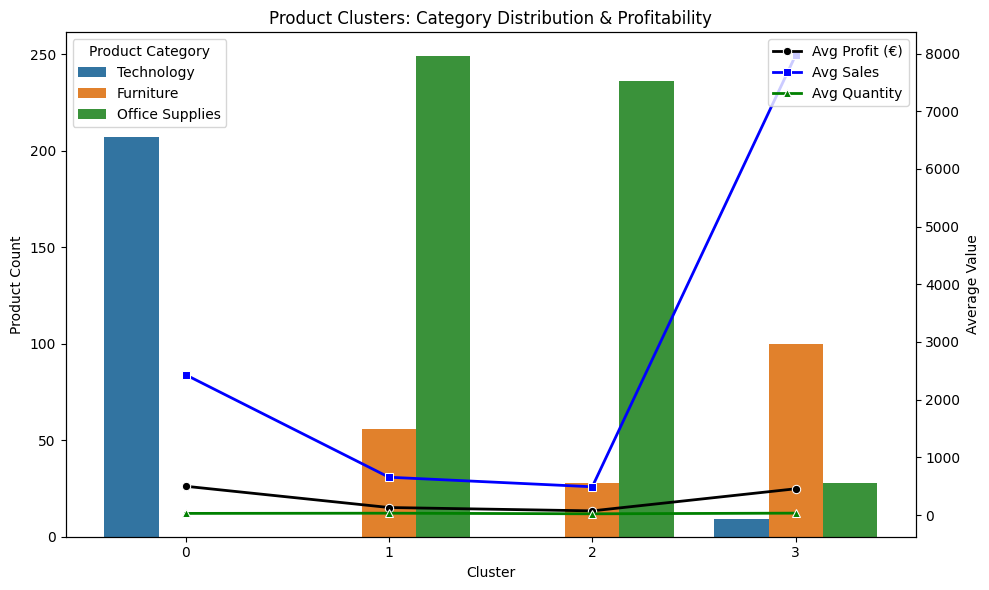

In [86]:
# ----------- Prepare data ----------- #
# Count of products by cluster and category
category_counts = product_df.groupby(['Cluster', 'Product Category']) \
                            .size().reset_index(name='Product Count')

# Average profit, sales, and quantity per cluster
cluster_stats = product_df.groupby('Cluster').agg({
    'Profit': 'mean',
    'Sales': 'mean',
    'Quantity ordered new': 'mean'
}).reset_index()

# ----------- Plot ----------- #
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: product count by cluster and category
sns.barplot(data=category_counts, x='Cluster', y='Product Count',
            hue='Product Category', ax=ax1)
ax1.set_ylabel('Product Count')
ax1.set_xlabel('Cluster')
ax1.set_title('Product Clusters: Category Distribution & Profitability')

# Line plot: average profit by cluster
ax2 = ax1.twinx()
sns.lineplot(data=cluster_stats, x='Cluster', y='Profit',
             color='black', marker='o', linewidth=2, ax=ax2, label='Avg Profit (€)')
sns.lineplot(data=cluster_stats, x='Cluster', y='Sales',
             color='blue', marker='s', linewidth=2, ax=ax2, label='Avg Sales')
sns.lineplot(data=cluster_stats, x='Cluster', y='Quantity ordered new',
             color='green', marker='^', linewidth=2, ax=ax2, label='Avg Quantity')

ax2.set_ylabel('Average Value')

# Legend and layout
ax1.legend(title='Product Category', loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [88]:
product_df.groupby('Cluster')[['Sales', 'Profit', 'Discount', 'Quantity ordered new', 'Shipping Cost', 'Unit Price', 'Product Base Margin']].mean().reset_index()

,Cluster,Sales,Profit,Discount,Quantity ordered new,Shipping Cost,Unit Price,Product Base Margin
0,0,2431.523382,498.551403,0.047565,27.763285,8.638510,128.729179,0.557810
1,1,655.049180,129.966460,0.029249,31.308197,6.839328,26.560361,0.460660
2,2,489.462424,71.764143,0.072181,21.007576,6.080821,32.857708,0.465995
3,3,7970.835474,454.685895,0.049290,32.306569,43.361204,357.146569,0.654956


In [87]:
customer_df.groupby('Cluster')[['Sales', 'Profit', 'Discount', 'Quantity ordered new', 'Shipping Cost', 'Unit Price', 'Product Base Margin']].mean().reset_index()

,Cluster,Sales,Profit,Discount,Quantity ordered new,Shipping Cost,Unit Price,Product Base Margin
0,0,1065.798616,105.263451,0.049650,17.370536,22.879777,85.027141,0.525061
1,1,811.397837,134.502472,0.053317,14.735577,16.441587,77.473902,0.520881
2,2,1147.197695,66.971851,0.046537,18.342007,19.105725,98.956238,0.500942
3,3,1079.464463,-8.441599,0.048320,17.473829,19.375813,104.900248,0.514779
4,4,12369.491818,2387.438742,0.046817,106.590909,69.637121,280.564989,0.531825
